In [1]:
import warnings

warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap.umap_ as umap

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set(rc={'figure.figsize':(13, 13)})

# Задачи

Для датасета из домашнего задания номер 9 (есть ли у человека диабет по предоставленным данным) исследовать связь качества классификации и количества признаков. Для этого использовать алгоритм понижения размерности PCA.


  1. Препроцессинг данных и базовую модель можно взять из ДЗ 9
  2. Построить PCA для размерности N
  3. Исследовать explained_variance_ratio_ для такого разложения
  4. Построить график изменения variance
  5. Определить отрезок с наиболее высоким значением вариантивности (90-99%)
  6. Построить ту же модель из ДЗ 9 для различного количества компонент из выбранного промежутка
  7. Оценить точность такой модели
  8. Сделать выводы о том как меняется точность модели с изменением кол-ва главных компонент
  9. Визуализировать данные с помощью PCA n_components=2
  10. Построить матрицу корреляций для данных после PCA. Что можно о ней сказать?


# ***Optional:***

  * Использовать tSNE для понижения размерности c различными параметрами и повторить пункты 6-9, сравнив размерность

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lesson_12/pima-indians-diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Class                     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe(include = 'all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Иммем довольно хорошую на первый взгляд картину. Нет  NaN, все данные представлены в числовом виде. Так что не нужно преобразововать object в int. Посмотрим что у нас с балансом классов

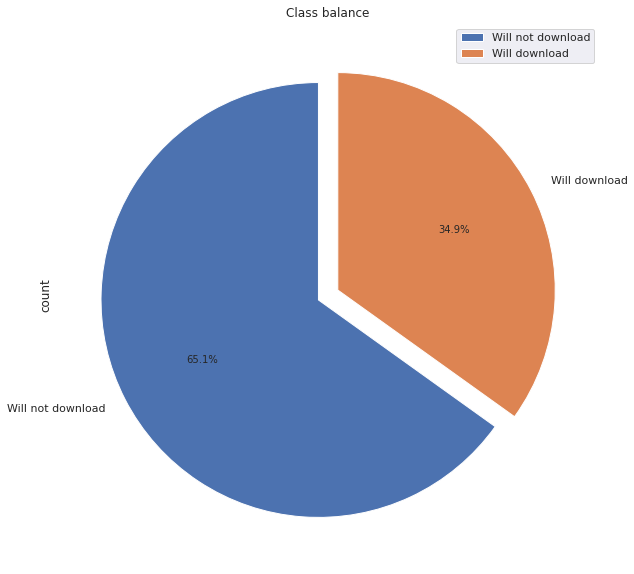

In [5]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")

pd.DataFrame(
    {'count': [df['Class'].isin([0]).sum(),
               df['Class'].isin([1]).sum()]},
    index=['Will not download','Will download']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=ax)

plt.show()

Баланс классов довольно не плохой. По сравнению с тем, что приходилось работать в задании 10 и 11. Что не может не радовать. 

Посмотрим на распределение

In [23]:
def distPlot(dfs):
  sns.set(rc={'figure.figsize':(10, 8)})
  # Define the number of rows and columns you want
  n_rows=3
  n_cols=3
  # Create the subplots
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

  for i, column in enumerate(dfs.columns):
      sns.distplot(dfs[column],ax=axes[i//n_cols,i%n_cols])

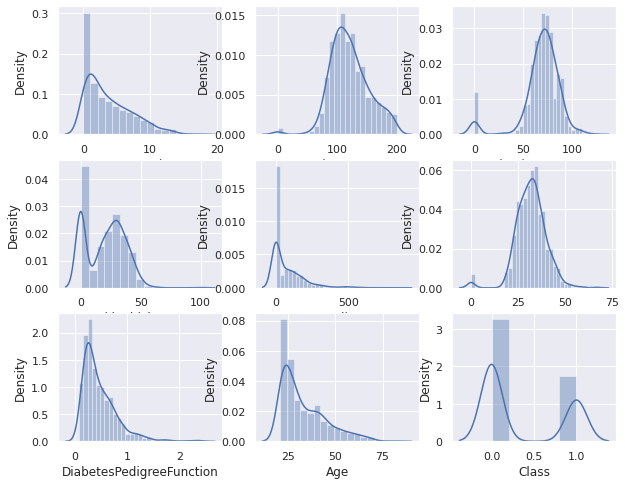

In [24]:
distPlot(df)

так как такие значения как BloodPressure и Insulin имеют большой размах, то мы используем StandardScaler()

In [8]:
scaled_df = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Class'], axis=1)),columns = df.drop(['Class'], axis=1).columns).join(df[['Class']])
scaled_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1
...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136,0
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023,0
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732,1


Посмотрим на корреляцию

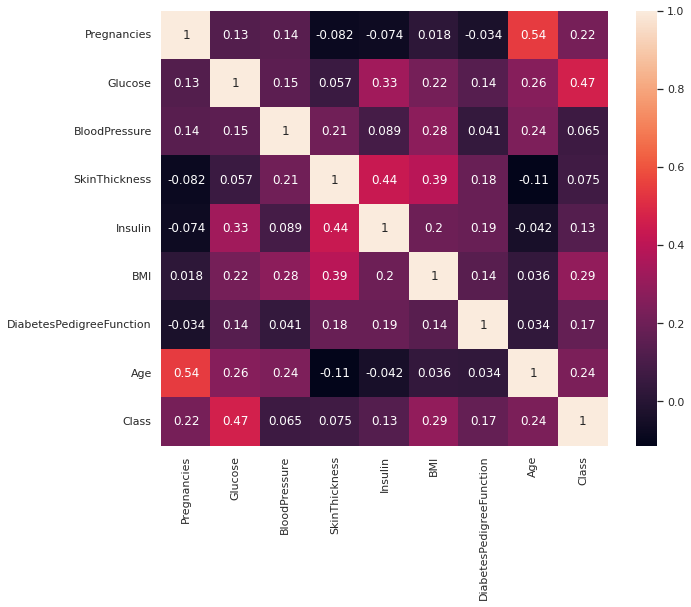

In [9]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot = True)

# PCA N=8

Здесь я применю PCA N = 8, то есть по размерности M датасета, просто хочу посмотреть что из этого выйдет.

In [10]:
df_columns = df.drop(['Class'], axis=1)

In [11]:
PCA_8 = PCA(n_components=8, random_state=42)
PCA_8.fit(df_columns)

PCA(n_components=8, random_state=42)

In [12]:
PCA_8_df = pd.DataFrame(PCA_8.fit_transform(df_columns), columns=df_columns.columns.values).join(df[['Class']])
PCA_8_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,-75.714655,-35.950783,-7.260789,15.669269,16.506541,3.460442,-0.702047,0.094977,1
1,-82.358268,28.908213,-5.496671,9.004554,3.481527,5.590262,-2.572015,-0.091535,0
2,-74.630643,-67.906496,19.461808,-5.653056,-10.300113,7.144367,4.279067,0.271011,1
3,11.077423,34.898486,-0.053018,1.314873,-7.619414,2.583855,-0.809829,-0.273305,0
4,89.743788,-2.746937,25.212859,18.994237,8.522694,-9.486986,-3.626410,1.674348,1
...,...,...,...,...,...,...,...,...,...
763,99.237881,25.080927,-19.534825,4.438332,35.616971,3.615785,1.341049,-0.400786,0
764,-78.641239,-7.688010,-4.137227,13.740154,-4.532273,-2.519062,-0.934381,-0.139252,0
765,32.113198,3.376665,-1.587864,-0.878445,-2.979288,6.239038,1.725065,-0.211528,0
766,-80.214494,-14.186020,12.351264,-14.294259,8.532950,-2.842307,-5.127928,-0.097191,1


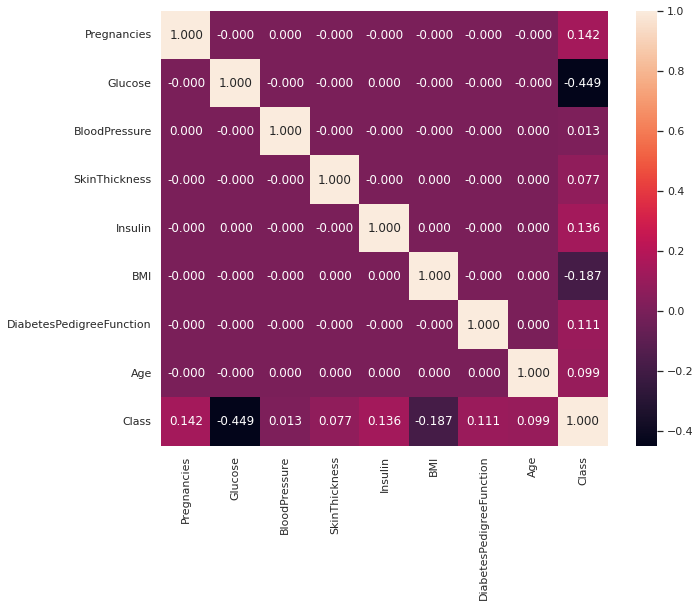

In [13]:
sns.heatmap(PCA_8_df.corr(), annot=True, fmt='.3f')

Как видим, PCA может являтся хорошим средством "борьбы" против корреляций и при этом не удаляя нечего из датасета, что важно

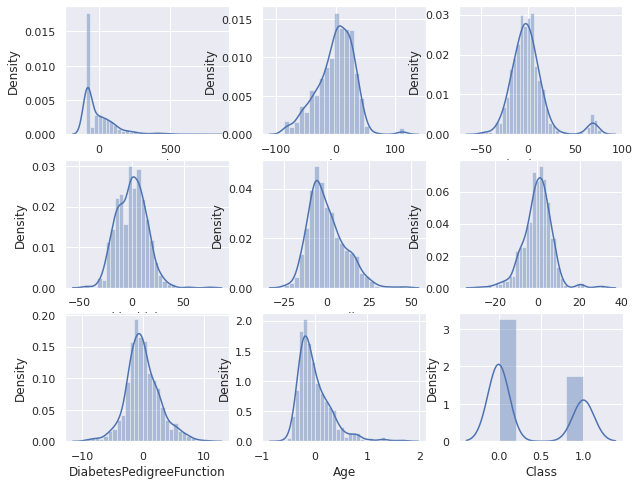

In [14]:
distPlot(PCA_8_df)

Сравнив графики распределения, можно увидеть разницу. Например, DiabetesPedigreeFunction из логинормальной стало нормальным, а Age - Пуассона. То есть применив PCA мы изменили распределения значений в более удобный для дальнейшего анализа.

# PCA N=6

Если до этого мы просто посмотрели как меняется наш датасет после PCA, то сейчас мы сравним что лучше. Просто убрать ненужные значения (с помощью дисперсионного анализа) или применить PCA.

In [15]:
def ForestClass(dataset, class_column, title):
    
    X = dataset.drop([class_column], axis=1)
    y = dataset[[class_column]]
  
    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    experiment_cv_scoes = cross_val_score(estimator=clf, X = X, y = y.to_numpy().flatten(), cv=kf, scoring='f1')

    return experiment_cv_scoes.mean()

In [16]:
X = scaled_df.drop(['Class'], axis=1)
y = scaled_df[['Class']]

selector_6 = SelectKBest(f_classif, k=6)
selector_6.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols_6 = selector_6.get_support(indices=True)
df_new_6 = X.iloc[:,cols_6].join(scaled_df['Class'])
df_new_6

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,0.639947,0.848324,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,0.765836,1.409746,5.484909,-0.020496,1
...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.870031,0.115169,-0.908682,2.532136,0
764,-0.547919,0.034598,-0.692891,0.610154,-0.398282,-0.531023,0
765,0.342981,0.003301,0.279594,-0.735190,-0.685193,-0.275760,0
766,-0.844885,0.159787,-0.692891,-0.240205,-0.371101,1.170732,1


In [17]:
test_1 = ForestClass(df_new_6, 'Class', 'DPF and Age dopped.')

PCA_6 = PCA(n_components=6, random_state=42)
pca_6_values = PCA_6.fit_transform(X=scaled_df)

X = pd.DataFrame(data=pca_6_values, columns=df_columns.columns[:6:]).join(scaled_df[['Class']])
test_2 = ForestClass(X, 'Class', 'Scaled dataset decomposition to 6 components.')

print("Scores for:\n\t- Dropped DPF and Age features: {:.6f}\n\t- Decomposition to N=6: {:.9f}".format(test_1, test_2))

Scores for:
	- Dropped DPF and Age features: 0.628490
	- Decomposition to N=6: 0.679976295


Для выбора 6 фич но без преобразования использовался критерий Фишера. Как видим, тот работает в разы хуже чем PCA для нашей задачи. Это работает не всегда. Иногда лучше выбирать и не преобразовывать значения. Но в нашем случае лучше PCA

In [18]:
def plot_variance(dfs, target, n):

  features = dfs.drop(columns = [target]).columns.to_list()

  pca = PCA(n_components = n, random_state = 42)
  components = pca.fit_transform(df[features])
  total_var = pca.explained_variance_ratio_.sum() * 100

  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
  }

  fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(n),
    color = dfs[target],
    title = f'Total Explained Variance: {total_var:.2f}%',
  )
  fig.update_traces(diagonal_visible=False)
  fig.show()

In [19]:
plot_variance(scaled_df, 'Class', 6)

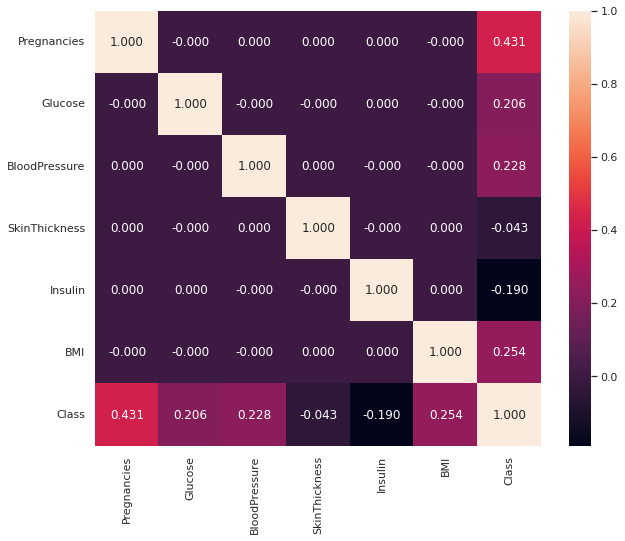

In [20]:
sns.heatmap(X.corr(), annot=True, fmt='.3f');

# PCA N=2

Тут я не только нарисую графики при PCA N=2 но и сравню работу PCA с другими методами уменьшения размерности. Делть это буду поочередно чтобы потом построить графики

In [22]:
tsne_res = {}
umap_res = {}
pca_res = {}
# lda_res = {} Была попытка создать, но не получалось по причине что n_components не может быть больше чем min(n_features, n_classes - 1). То есть 1... Мне такое не подходило.

decomp_results = {'TSNE':tsne_res, 'UMAP': umap_res, 'PCA': pca_res}

for idx in np.arange(2, 9)[::-1]:
    print("N = ", idx)
    pca = PCA(n_components=idx, random_state=42)
    tsne = TSNE(n_components=idx, random_state=42, method='exact', n_jobs=-1)
    umap_work = umap.UMAP(n_components=idx, random_state=42, n_jobs=-1)
    lda = LinearDiscriminantAnalysis(n_components=idx)

    pca_res[idx] = pca.fit_transform(scaled_df.drop(columns = ['Class']))
    tsne_res[idx] = tsne.fit_transform(scaled_df.drop(columns = ['Class']))
    umap_res[idx] = umap_work.fit_transform(scaled_df.drop(columns = ['Class']))
    # lda_res[idx] = lda.fit_transform(scaled_df.drop(columns = ['Class']), scaled_df['Class'])

N =  8
N =  7
N =  6
N =  5
N =  4
N =  3
N =  2


Теперь применю рандомный лесс для всех и запишу результаты. Тем самым сравню

In [34]:
scores = {}

idx = 1
for decompositor in decomp_results:
    scores[decompositor] = {}

    for n in decomp_results[decompositor]:
        df = pd.DataFrame(data = decomp_results[decompositor][n], columns=scaled_df.drop(columns=['Class']).columns[:n:]).join(scaled_df[['Class']])
        score = ForestClass(df, 'Class', '')
        scores[decompositor][n] = score
    
    idx += 1

Посмотрим как выглядят разные методы понижения размерности при N=2

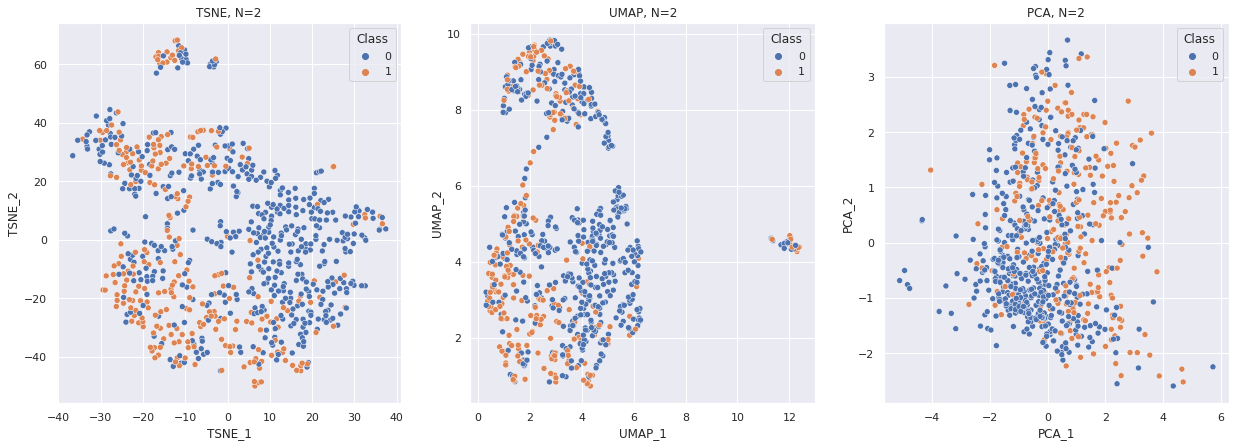

In [35]:
figure, axis = plt.subplots(1, 3, figsize=(21, 7))
axs = axis.flatten()

idx=0
for decompositor in decomp_results:
    x_col = decompositor + '_1'
    y_col = decompositor + '_2'
    df = pd.DataFrame(data = decomp_results[decompositor][2], columns=[x_col, y_col]).join(scaled_df[['Class']])
    sns.scatterplot(data=df, x=x_col, y=y_col, hue="Class", ax=axs[idx])
    axs[idx].set_title(decompositor + ", N=2")
    idx += 1
    
plt.show()

Как по мне, PCA получше справился так как в нем нет непонятных выбросов как это есть в TSNE и UMAP.

И корреляцию (вдруг что-то поменялось)

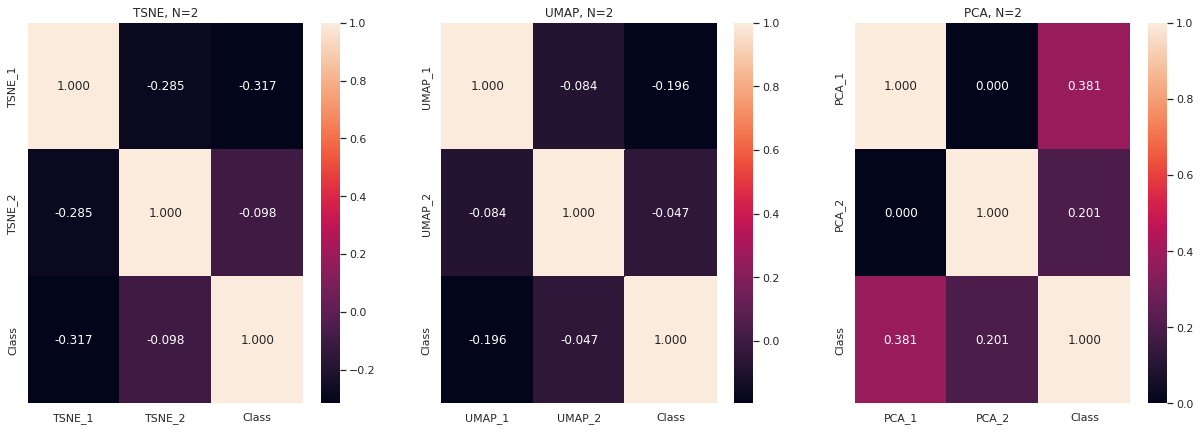

In [38]:
figure, axis = plt.subplots(1, 3, figsize=(21, 7))
axs = axis.flatten()

idx=0
for decompositor in decomp_results:
    x_col = decompositor + '_1'
    y_col = decompositor + '_2'
    df = pd.DataFrame(data = decomp_results[decompositor][2], columns=[x_col, y_col]).join(scaled_df[['Class']])
    sns.heatmap(data=df.corr(), annot=True, fmt='.3f', ax=axs[idx])
    # (X.corr(), annot=True, fmt='.3f')
    axs[idx].set_title(decompositor + ", N=2")
    idx += 1
    
plt.show()

Уже видно что корреляция не становится 0 когда применяем UMAP и TSNE. При PCA же все как всегда.

Теперь нарисуем график того что мы делали с рандомным лесом и посмотрим какой метод выдает лучше результат и при каком N, а также сравним тенденцию

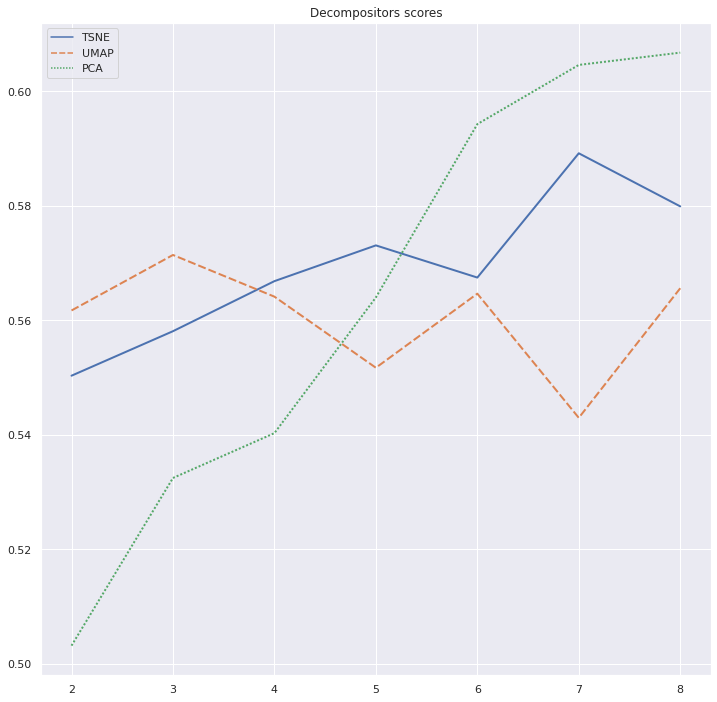

In [41]:
figure, axs = plt.subplots(1, 1, figsize=(12, 12))

scores_df = pd.DataFrame()

for decompositor in scores:
    scores_df[decompositor] = scores[decompositor].values()

scores_df.index = np.arange(2, 9)[::-1]
sns.lineplot(data=scores_df, ax=axs, linewidth=2)

axs.set_title('Decompositors scores')
plt.show()

Как видим можно сделать выводы,что PCA имеет тенденицию роста при большем числе N. Но при этом когда N=2 та справляется напорядок хуже всех остольных методов. И наоборот лучше всех при N=8. UMAP же наоборот при N=2 показывала найлучший результат, а при N=8 - худший, но при этом значение F1 не сильно поменялось. То есть UMAP более "устойчева" (Есть падения но они незначительеы). TSNE улучшил свои показатели, но в отличии от PCA были незначительные падения.

# Выводы

* PCA является отлчным методом при высокой корреляции значений. Можно значительно уменьшить корреляцию и при этом не удалять значения.
* По графикам выше видно, что чем меньше число N в PCA тем хуже работает метод классификации. Конечно же не всегда так может быть и иногда уменьшение размерности может принести огромную пользу в расчетах, но не в нашем примере.
* UMAP не сильно изменила свой результат при изменении N. И при этом UMAP справился лучше остольных при понижении размерности до двух значений
* При сравнении Feature Selection и Dimensionality reduction, лучше всего отработал Dimensionality reduction. Конечно же не всегда такое возможно и преобразование может существенно ухудшить работу, но в нашем случае такого не произошло